This notebook is focused on aggregating classification cross-validation statistics and summarizing the per-cohort attributes (i.e. age distributions and sex ratios.)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summarize-results" data-toc-modified-id="Summarize-results-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summarize results</a></span></li><li><span><a href="#Reload-figures-here" data-toc-modified-id="Reload-figures-here-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reload figures here</a></span></li><li><span><a href="#Reload-results-to-plot-results" data-toc-modified-id="Reload-results-to-plot-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reload results to plot results</a></span></li></ul></div>

Here, we will construct put together some classification benchmarks for conditional logistic regression, random forests and SVMs using the results from the cross-validation.

In [1]:
# This block is just for importing the necessary libraries.  
import os
import pickle
from collections import defaultdict

# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis

from statsmodels.discrete.conditional_models import ConditionalLogit
from patsy import dmatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from logit import conditional_logistic_regression, clogit_predict
from plot import (rankplot, networkplot, vectorplot)
import random
import warnings
warnings.simplefilter('ignore')

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

pd.options.display.max_rows = 100 

Cross-validation parameters

In [2]:
cv_params = pd.DataFrame(
    [
        ('SVM', '16S', 'C', 10 ** -0.39766725031781125),
        ('SVM', '16S', 'Gamma', 10 ** -2.8760981556423375),
        ('RandomForest', '16S', 'max_features', 0.373582833227288),
        ('RandomForest', '16S', 'min_samples_split', 14),
        ('RandomForest', '16S', 'n_estimators', 97),
        ('CLogit', '16S', 'L1_wt', np.exp(-3.2846856813934586) / (1 + np.exp(-3.2846856813934586))),
        ('CLogit', '16S', 'alpha', np.exp(-19.567528379050646) / (1 + np.exp(-19.567528379050646))),

        ('SVM', 'WGS', 'C', 10 ** -2.7696090036324983),
        ('SVM', 'WGS', 'Gamma', 10 ** -2.376736745339439),
        ('RandomForest', 'WGS', 'max_features', 0.4897508493946866),
        ('RandomForest', 'WGS', 'min_samples_split', 17),
        ('RandomForest', 'WGS', 'n_estimators', 230),
        ('CLogit', 'WGS', 'L1_wt', np.exp(-13.244950338123328) / (1 + np.exp(-13.244950338123328))),
        ('CLogit', 'WGS', 'alpha', np.exp(-10.214109609730592) / (1 + np.exp(-10.214109609730592))),
    ], columns=['method', 'data_type', 'variable_name', 'value']
)

cv_params = cv_params.set_index(['method', 'data_type', 'variable_name'])['value'].to_dict()

Pull out data tables

In [3]:
# load biom tables
amp_biom = biom.load_table(f'{kang_directory}/age_sex_match_week0_ogu.biom')
wgs_biom = biom.load_table(f'{wgs_directory}/ogus_table.biom')
amp_table = amp_biom.to_dataframe().T
wgs_table = wgs_biom.to_dataframe().T

# load metadata tables
amp_md = pd.read_table(f'{kang_directory}/combined_sample_metadata_0.txt', index_col=0)
wgs_md = pd.read_table(f'{wgs_directory}/sample_metadata.txt', index_col=0)

amp_md = amp_md.sort_values(['Status', 'Match_IDs'])
wgs_md = wgs_md.sort_values(['Status', 'Match_IDs'])

amp_table = amp_table.loc[amp_md.index]
wgs_table = wgs_table.loc[wgs_md.index]

# load taxonomy
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# load differentials
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v5.nc'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=50, log_probs=True)
wgs_stats = ranking(wgs_diffs, reference_percentile=50) 

sort_col = 'mean'

# collapse table by genus
cols = ['kingdom' ,'phylum', 'class', 'order', 'family', 'genus']
genus_lineage = mapping.apply(lambda x: ';'.join(map(str, x[cols])), axis=1)

amp_genera = pd.merge(amp_table.T, pd.DataFrame({'genus': genus_lineage}), 
                      left_index=True, right_index=True).groupby('genus').sum()

wgs_genera = pd.merge(wgs_table.T, pd.DataFrame({'genus': genus_lineage}), 
                      left_index=True, right_index=True).groupby('genus').sum()

# clr transform
amp_gclr = np.log(amp_genera + 1).T - np.log(amp_genera + 1).T.mean(axis=1).values.reshape(-1, 1)
wgs_gclr = np.log(wgs_genera + 1).T - np.log(wgs_genera + 1).T.mean(axis=1).values.reshape(-1, 1)

# train / test split
amp_state = np.random.RandomState(0)
cohorts = amp_md['Cohort'].unique()
matches = amp_state.permutation(amp_md['Match_IDs'].unique())
amp_train = matches[len(matches) // 4:]
amp_test = matches[:len(matches) // 4]

wgs_state = np.random.RandomState(0)
cohorts = wgs_md['Cohort'].unique()
matches = wgs_state.permutation(wgs_md['Match_IDs'].unique())
wgs_train = matches[len(matches) // 4:]
wgs_test = matches[:len(matches) // 4]

Train classifiers

Amplicon classifiers

In [4]:
train_idx = amp_md['Match_IDs'].apply(lambda x: x in amp_train)
test_idx = amp_md['Match_IDs'].apply(lambda x: x in amp_test)
amp_svm = SVC(
    C=cv_params[('SVM', '16S', 'C')], 
    gamma=cv_params[('SVM', '16S', 'Gamma')], random_state=2
).fit(X=amp_gclr.loc[train_idx].values, y=amp_md.loc[train_idx, 'Status'].values)
amp_svm_train_pred = amp_svm.predict(X=amp_gclr.loc[train_idx].values)
amp_svm_test_pred = amp_svm.predict(X=amp_gclr.loc[test_idx].values)

amp_rf = RandomForestClassifier(
    max_features=cv_params[('RandomForest', '16S', 'max_features')], 
    min_samples_split=int(cv_params[('RandomForest', '16S', 'min_samples_split')]), 
    n_estimators=int(cv_params[('RandomForest', '16S', 'n_estimators')]), 
    random_state=2
).fit(X=amp_gclr.loc[train_idx].values, y=amp_md.loc[train_idx, 'Status'].values)
amp_rf_train_pred = amp_rf.predict(X=amp_gclr.loc[train_idx].values)
amp_rf_test_pred = amp_rf.predict(X=amp_gclr.loc[test_idx].values)
"""
train_p, test_p, amp_clogit = conditional_logistic_regression(
    amp_gclr, amp_md, 'Match_IDs', 'Status',
    train_idx, test_idx, 
    alpha=cv_params[('CLogit', '16S', 'alpha')], 
    L1_wt=cv_params[('CLogit', '16S', 'L1_wt')])
amp_clogit_train_pred, amp_clogit_test_pred = np.round(train_p), np.round(test_p)
amp_clogit_params = amp_clogit.params
"""

"\ntrain_p, test_p, amp_clogit = conditional_logistic_regression(\n    amp_gclr, amp_md, 'Match_IDs', 'Status',\n    train_idx, test_idx, \n    alpha=cv_params[('CLogit', '16S', 'alpha')], \n    L1_wt=cv_params[('CLogit', '16S', 'L1_wt')])\namp_clogit_train_pred, amp_clogit_test_pred = np.round(train_p), np.round(test_p)\namp_clogit_params = amp_clogit.params\n"

WGS classifiers

In [5]:
train_idx = wgs_md['Match_IDs'].apply(lambda x: x in wgs_train)
test_idx = wgs_md['Match_IDs'].apply(lambda x: x in wgs_test)
wgs_svm = SVC(
    C=cv_params[('SVM', 'WGS', 'C')], 
    gamma=cv_params[('SVM', 'WGS', 'Gamma')], random_state=2
).fit(X=wgs_gclr.loc[train_idx].values, y=wgs_md.loc[train_idx, 'Status'].values)
wgs_svm_train_pred = wgs_svm.predict(X=wgs_gclr.loc[train_idx].values)
wgs_svm_test_pred = wgs_svm.predict(X=wgs_gclr.loc[test_idx].values)

wgs_rf = RandomForestClassifier(
    max_features=cv_params[('RandomForest', 'WGS', 'max_features')], 
    min_samples_split=int(cv_params[('RandomForest', 'WGS', 'min_samples_split')]), 
    n_estimators=int(cv_params[('RandomForest', 'WGS', 'n_estimators')]), 
    random_state=2
).fit(X=wgs_gclr.loc[train_idx].values, y=wgs_md.loc[train_idx, 'Status'].values)
wgs_rf_train_pred = wgs_rf.predict(X=wgs_gclr.loc[train_idx].values)
wgs_rf_test_pred = wgs_rf.predict(X=wgs_gclr.loc[test_idx].values)
"""
train_p, test_p, wgs_clogit = conditional_logistic_regression(
    wgs_gclr, wgs_md, 'Match_IDs', 'Status',
    train_idx, test_idx, 
    alpha=cv_params[('CLogit', 'WGS', 'alpha')], 
    L1_wt=cv_params[('CLogit', 'WGS', 'L1_wt')])
wgs_clogit_train_pred, wgs_clogit_test_pred = np.round(train_p), np.round(test_p)
wgs_clogit_params = wgs_clogit.params
"""

"\ntrain_p, test_p, wgs_clogit = conditional_logistic_regression(\n    wgs_gclr, wgs_md, 'Match_IDs', 'Status',\n    train_idx, test_idx, \n    alpha=cv_params[('CLogit', 'WGS', 'alpha')], \n    L1_wt=cv_params[('CLogit', 'WGS', 'L1_wt')])\nwgs_clogit_train_pred, wgs_clogit_test_pred = np.round(train_p), np.round(test_p)\nwgs_clogit_params = wgs_clogit.params\n"

Load classifiers and results

In [6]:
amp_clogit_params = pd.read_csv('../results/classifiers/amplicon-conditional-logit.csv', index_col=0)
wgs_clogit_params = pd.read_csv('../results/classifiers/wgs-conditional-logit.csv', index_col=0)

# Summarize results

We will break down the cross-validation accuracy into (1) training accuracy and (2) testing accuracy across each of the cohorts.

In [7]:
def per_cohort_summary(metadata, y_pred, outcome_col, cohort_col, method, datatype, split):
    summaries = {}
    for cohort_name, md in metadata.groupby(cohort_col):
        y_true = md[outcome_col]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred.loc[md.index]).ravel()
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        acc = (tp + tn) / (tp + tn + fp + fn)
        summaries[cohort_name] = {'specificity': tpr, 'sensitivity': tnr, 
                                  'accuracy': acc}
    summaries = pd.DataFrame(summaries).T
    summaries['Method'] = method
    summaries['DataType'] = datatype
    summaries['Split'] = split
    return summaries

def overall_summary(md, y_pred, outcome_col):
    y_true = md[outcome_col]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    return {'specificity': tpr, 'sensitivity': tnr, 
            'accuracy': acc}

In [8]:
cv_results = {}

# amplicon results
train_idx = amp_md['Match_IDs'].apply(lambda x: x in amp_train)
test_idx = amp_md['Match_IDs'].apply(lambda x: x in amp_test)

cv_results[('SVM', '16S', 'train')] = overall_summary(
    amp_md.loc[train_idx], amp_svm_train_pred, 'Status')
cv_results[('SVM', '16S', 'test')] = overall_summary(
    amp_md.loc[test_idx], amp_svm_test_pred, 'Status')

cv_results[('RandomForest', '16S', 'train')] = overall_summary(
    amp_md.loc[train_idx], amp_rf_train_pred, 'Status')
cv_results[('RandomForest', '16S', 'test')] = overall_summary(
    amp_md.loc[test_idx], amp_rf_test_pred, 'Status')

# shotgun results
train_idx = wgs_md['Match_IDs'].apply(lambda x: x in wgs_train)
test_idx = wgs_md['Match_IDs'].apply(lambda x: x in wgs_test)

cv_results[('SVM', 'WGS', 'train')] = overall_summary(
    wgs_md.loc[train_idx], wgs_svm_train_pred, 'Status')
cv_results[('SVM', 'WGS', 'test')] = overall_summary(
    wgs_md.loc[test_idx], wgs_svm_test_pred, 'Status')

cv_results[('RandomForest', 'WGS', 'train')] = overall_summary(
    wgs_md.loc[train_idx], wgs_rf_train_pred, 'Status')
cv_results[('RandomForest', 'WGS', 'test')] = overall_summary(
    wgs_md.loc[test_idx], wgs_rf_test_pred, 'Status')

Per cohort summaries

In [9]:
cv_cohort_amp_results = {}

# amplicon results
train_idx = amp_md['Match_IDs'].apply(lambda x: x in amp_train)
test_idx = amp_md['Match_IDs'].apply(lambda x: x in amp_test)

cv_cohort_amp_results = pd.concat((
    per_cohort_summary(
        amp_md.loc[train_idx], pd.Series(amp_svm_train_pred, index=amp_md.loc[train_idx].index), 
        'Status', 'Cohort', 'SVM', '16S', 'train'),
    per_cohort_summary(
        amp_md.loc[test_idx], pd.Series(amp_svm_test_pred, index=amp_md.loc[test_idx].index), 
        'Status', 'Cohort', 'SVM', '16S', 'test'),    
    per_cohort_summary(
        amp_md.loc[train_idx], pd.Series(amp_rf_train_pred, index=amp_md.loc[train_idx].index), 
        'Status', 'Cohort', 'RandomForest', '16S', 'train'),
    per_cohort_summary(
        amp_md.loc[test_idx], pd.Series(amp_rf_test_pred, index=amp_md.loc[test_idx].index), 
        'Status', 'Cohort', 'RandomForest', '16S', 'test')
))


train_idx = wgs_md['Match_IDs'].apply(lambda x: x in wgs_train)
test_idx = wgs_md['Match_IDs'].apply(lambda x: x in wgs_test)
cv_cohort_wgs_results = pd.concat((
    per_cohort_summary(
        wgs_md.loc[train_idx], pd.Series(wgs_svm_train_pred, index=wgs_md.loc[train_idx].index), 
        'Status', 'Cohort', 'SVM', 'WGS', 'train'),
    per_cohort_summary(
        wgs_md.loc[test_idx], pd.Series(wgs_svm_test_pred, index=wgs_md.loc[test_idx].index), 
        'Status', 'Cohort', 'SVM', 'WGS', 'test'),    
    per_cohort_summary(
        wgs_md.loc[train_idx], pd.Series(wgs_rf_train_pred, index=wgs_md.loc[train_idx].index), 
        'Status', 'Cohort', 'RandomForest', 'WGS', 'train'),
    per_cohort_summary(
        wgs_md.loc[test_idx], pd.Series(wgs_rf_test_pred, index=wgs_md.loc[test_idx].index), 
        'Status', 'Cohort', 'RandomForest', 'WGS', 'test')
))

In [10]:
cv_results = pd.DataFrame(cv_results).T.reset_index()
cv_results = cv_results.rename(columns={'level_0': 'Method', 'level_1': 'DataType', 'level_2': 'Split'})
cv_results.index = ['Overall'] * len(cv_results)
cv_all_results = pd.concat((cv_results, cv_cohort_amp_results, cv_cohort_wgs_results))
cv_all_results = cv_all_results.reset_index().rename(columns={'index': 'Cohort'})
cv_all_results.to_csv('../results/classifiers/cv_results.csv')

# Reload figures here

In [11]:
cv_all_results = pd.read_csv('../results/classifiers/cv_results.csv', index_col=0)

In [12]:
cv_all_results

,Cohort,Method,DataType,Split,specificity,sensitivity,accuracy
0,Overall,SVM,16S,train,0.893993,0.848057,0.871025
1,Overall,SVM,16S,test,0.776596,0.670213,0.723404
2,Overall,RandomForest,16S,train,1.000000,1.000000,1.000000
3,Overall,RandomForest,16S,test,0.659574,0.680851,0.670213
4,Overall,SVM,WGS,train,1.000000,1.000000,1.000000
5,Overall,SVM,WGS,test,0.100000,1.000000,0.550000
6,Overall,RandomForest,WGS,train,1.000000,1.000000,1.000000
7,Overall,RandomForest,WGS,test,0.850000,0.700000,0.775000
8,Berding2020,SVM,16S,train,0.923077,1.000000,0.961538
9,Chen2020,SVM,16S,train,0.818182,0.757576,0.787879


Summaries for conditional logit

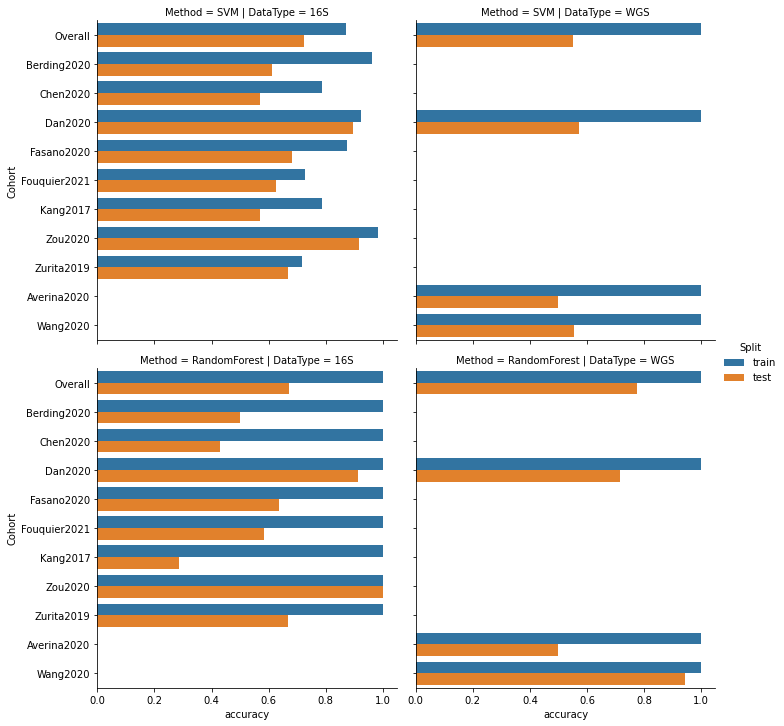

In [13]:
sns.factorplot(data=cv_all_results, y='Cohort', x='accuracy', 
               hue='Split', row='Method', col='DataType', kind='bar', orient='h')

In [14]:
def control_pairing(md, cohort, split, match_columns, types):
    mds = []
    for name, md in md.groupby([cohort, split]):
        k = 0
        cohort_name, split_name = name
        md['Control_pair'] = None
        observed = set()
        for i in range(len(md)):
            for j in range(i):
                if ((md.iloc[i]['Sex'] == md.iloc[j]['Sex'] or md.iloc[i]['Sex'] == "Unknown") 
                    and np.abs(md.iloc[i]['Age'] - md.iloc[j]['Age']) <= 2):
                    if i not in observed and j not in observed:
                        md.loc[md.index[i], 'Control_pair'] = f'{cohort_name}_{k}'
                        md.loc[md.index[j], 'Control_pair'] = f'{cohort_name}_{k}'
                        k += 1
                        observed.add(i)
                        observed.add(j)                               
        mds.append(md)
    return pd.concat(mds)


def clogit_predict(X, beta, groups):
    """ Assumes that groups is ordered. """
    cats = np.unique(groups)
    pred = []
    for c in cats:
        idx = [groups == c]
        X_ = X[idx]
        p = np.exp(X_[0] @ beta) / (np.exp(X_[0] @ beta) + np.exp(X_[1] @ beta))
        pred.append(p)
    pred = pd.Series(np.ravel(pred), index=cats)
    return pred


def clogit_summary(table, md, params, outcome, case_control_matching, control_matching):
    # Looks at ASD vs Control
    md = md.sort_values([case_control_matching, outcome])
    y_cc_pred = clogit_predict(table.loc[md.index].values, params.values, md[case_control_matching].values)
    # Looks at Control vs Control
    md = md.sort_values([control_matching, outcome])
    md = md.dropna(subset=[control_matching, outcome])
    md = md.groupby(control_matching).filter(lambda x: len(x) == 2)
    y_c_pred = clogit_predict(table.loc[md.index].values, params.values, md[control_matching].values)
    # Compute confusion matrix
    y_pred = np.hstack((np.round(y_cc_pred.values.ravel()), np.round(y_c_pred.values.ravel())))
    y_true = np.hstack((np.ones(len(y_cc_pred)), np.zeros(len(y_c_pred))))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    return {'specificity': tpr, 'sensitivity': tnr, 
            'accuracy': acc}

def clogit_per_cohort_summary(table, metadata, params, outcome,
                              case_control_matching, control_matching, cohort,
                              method, datatype, split):
    summaries = {}
    for cohort_name, md in metadata.groupby(cohort):
        summaries[cohort_name] = clogit_summary(table.loc[md.index], md, params, outcome, 
                                                case_control_matching, control_matching)
    summaries = pd.DataFrame(summaries).T
    summaries['Method'] = method
    summaries['DataType'] = datatype
    summaries['Split'] = split
    return summaries

Obtain cross-validated conditional logistic regression for 16S

In [15]:
def split_f(x):
    if x in amp_train:
        return 'Train'
    return 'Test'

amp_md['Split'] = amp_md['Match_IDs'].apply(split_f)
amp_md2 = control_pairing(amp_md, 'Cohort', 'Split', ['Age', 'Sex'], [False, True])
train_idx = amp_md2['Match_IDs'].apply(lambda x: x in amp_train)
test_idx = amp_md2['Match_IDs'].apply(lambda x: x in amp_test)

clogit_cv_results = {}

clogit_cv_results[('ConditionalLogistic', '16S', 'train')] = clogit_summary(
    amp_gclr.loc[train_idx], 
    amp_md2.loc[train_idx], 
    amp_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair')

clogit_cv_train_amp_cohorts = clogit_per_cohort_summary(
    amp_gclr.loc[train_idx], 
    amp_md2.loc[train_idx], 
    amp_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair', 
    cohort='Cohort',
    method='ConditionalLogistic', 
    datatype='16S',
    split='train')

clogit_cv_results[('ConditionalLogistic', '16S', 'test')] = clogit_summary(
    amp_gclr.loc[test_idx], 
    amp_md2.loc[test_idx], 
    amp_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair')

clogit_cv_test_amp_cohorts = clogit_per_cohort_summary(
    amp_gclr.loc[test_idx], 
    amp_md2.loc[test_idx], 
    amp_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair', 
    cohort='Cohort',
    method='ConditionalLogistic', 
    datatype='16S',
    split='test')

Obtain cross-validated conditional logistic regression for 16S

In [16]:
def split_f(x):
    if x in wgs_train:
        return 'Train'
    return 'Test'
wgs_md['Split'] = wgs_md['Match_IDs'].apply(split_f)
wgs_md2 = control_pairing(wgs_md, 'Cohort', 'Split', ['Age', 'Sex'], [False, True])

train_idx = wgs_md2['Match_IDs'].apply(lambda x: x in wgs_train)
test_idx = wgs_md2['Match_IDs'].apply(lambda x: x in wgs_test)

clogit_cv_results[('ConditionalLogistic', 'WGS', 'train')] = clogit_summary(
    wgs_gclr.loc[train_idx], 
    wgs_md2.loc[train_idx], 
    wgs_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair')

clogit_cv_train_wgs_cohorts = clogit_per_cohort_summary(
    wgs_gclr.loc[train_idx], 
    wgs_md2.loc[train_idx], 
    wgs_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair', 
    cohort='Cohort',
    method='ConditionalLogistic', 
    datatype='WGS',
    split='train')

clogit_cv_results[('ConditionalLogistic', 'WGS', 'test')] = clogit_summary(
    wgs_gclr.loc[test_idx], 
    wgs_md2.loc[test_idx], 
    wgs_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair')

clogit_cv_test_wgs_cohorts = clogit_per_cohort_summary(
    wgs_gclr.loc[test_idx], 
    wgs_md2.loc[test_idx], 
    wgs_clogit_params, 'Status', 
    case_control_matching='Match_IDs', 
    control_matching='Control_pair', 
    cohort='Cohort',
    method='ConditionalLogistic', 
    datatype='WGS',
    split='test')

In [17]:
cv_all_results = pd.read_csv('../results/classifiers/cv_results.csv', index_col=0)

clogit_cv_results = pd.DataFrame(clogit_cv_results).T.reset_index()
clogit_cv_results = clogit_cv_results.rename(columns={'level_0': 'Method', 'level_1': 'DataType', 'level_2': 'Split'})
clogit_cv_results.index = ['Overall'] * len(clogit_cv_results)

clogit_cv_all_results = pd.concat((
    clogit_cv_results, 
    clogit_cv_train_amp_cohorts,
    clogit_cv_test_amp_cohorts,    
    clogit_cv_train_wgs_cohorts,
    clogit_cv_test_wgs_cohorts,
))
clogit_cv_all_results = clogit_cv_all_results.reset_index().rename(columns={'index': 'Cohort'})

cv_all_results = pd.concat((clogit_cv_all_results, cv_all_results))
cv_all_results.to_csv('../results/classifiers/cv_results.csv')

# Reload results to plot results

In [18]:
cv_all_results = pd.read_csv('../results/classifiers/cv_results.csv', index_col=0)

Sort entries

In [19]:
cv_all_results['Dataset'] = cv_all_results.apply(lambda x: x['Cohort'] + f" ({x['DataType']})", axis=1)

ordering = ['Berding2020 (16S)', 'Chen2020 (16S)', 'Zou2020 (16S)',
            'Dan2020 (16S)', 'Fouquier2021 (16S)', 'Kang2017 (16S)',
            'Zurita2019 (16S)', 'Fasano2020 (16S)', 'Overall (16S)',
            'Averina2020 (WGS)', 'Dan2020 (WGS)',
            'Wang2020 (WGS)', 'Overall (WGS)']

ordering = pd.DataFrame({'Ordering': np.arange(len(ordering))}, index=ordering)

cv_all_results = pd.merge(cv_all_results, ordering, left_on='Dataset', right_index=True)
cv_all_results = cv_all_results.sort_values('Ordering')

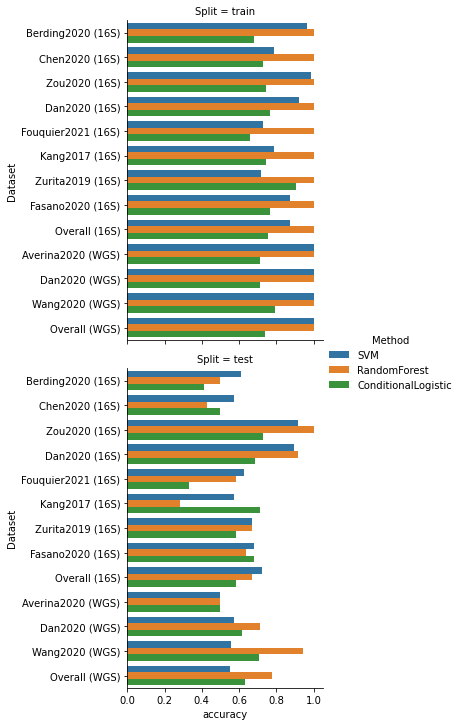

In [20]:
sns.factorplot(data=cv_all_results, y='Dataset', x='accuracy', 
               hue='Method', row='Split', kind='bar', orient='h')

Aggregate cohort specifics

In [21]:
amp_md['Dataset'] = amp_md.apply(lambda x: x['Cohort'] + f" (16S)", axis=1)
wgs_md['Dataset'] = wgs_md.apply(lambda x: x['Cohort'] + f" (WGS)", axis=1)

age_stats = pd.DataFrame({'mean_age': pd.concat((amp_md.groupby('Dataset')['Age'].mean(), 
                                     wgs_md.groupby('Dataset')['Age'].mean())),
                          'std_age': pd.concat((amp_md.groupby('Dataset')['Age'].std(), 
                                                wgs_md.groupby('Dataset')['Age'].std()))})
overall_age = pd.DataFrame({
    'mean_age': [amp_md['Age'].mean(), wgs_md['Age'].mean()],
    'std_age': [amp_md['Age'].std(), wgs_md['Age'].std()]
}, index=['Overall (16S)', 'Overall (WGS)'])
age_stats = pd.concat((age_stats, overall_age))
age_stats = pd.merge(age_stats, ordering, left_index=True, right_index=True)
age_stats = age_stats.sort_values('Ordering', ascending=False)

In [22]:
def mf_ratio(x, unknown=True):
    mf = x['Sex'].value_counts()
    if 'Unknown' in mf.index and unknown:
        return 0
    else:
        return mf['male'] / mf['female']
sex_stats = pd.DataFrame({
    'mf_ratio': pd.concat((amp_md.groupby('Dataset').apply(mf_ratio), 
                           wgs_md.groupby('Dataset').apply(mf_ratio)))
})
overall_sex = pd.DataFrame({
    'mf_ratio': [mf_ratio(amp_md, unknown=False), mf_ratio(wgs_md, unknown=False)],
}, index=['Overall (16S)', 'Overall (WGS)'])
sex_stats = pd.concat((sex_stats, overall_sex))

sex_stats = pd.merge(sex_stats, ordering, left_index=True, right_index=True)
sex_stats = sex_stats.sort_values('Ordering', ascending=False)

In [23]:
size_stats = pd.DataFrame({'sample_size': pd.concat((amp_md.groupby('Dataset').count()['Cohort'], 
                                                     wgs_md.groupby('Dataset').count()['Cohort']))})
overall_size = pd.DataFrame({
    'sample_size': [len(amp_md), len(wgs_md)],
}, index=['Overall (16S)', 'Overall (WGS)'])
size_stats = pd.concat((size_stats, overall_size))
size_stats = pd.merge(size_stats, ordering, left_index=True, right_index=True)
size_stats = size_stats.sort_values('Ordering', ascending=False)

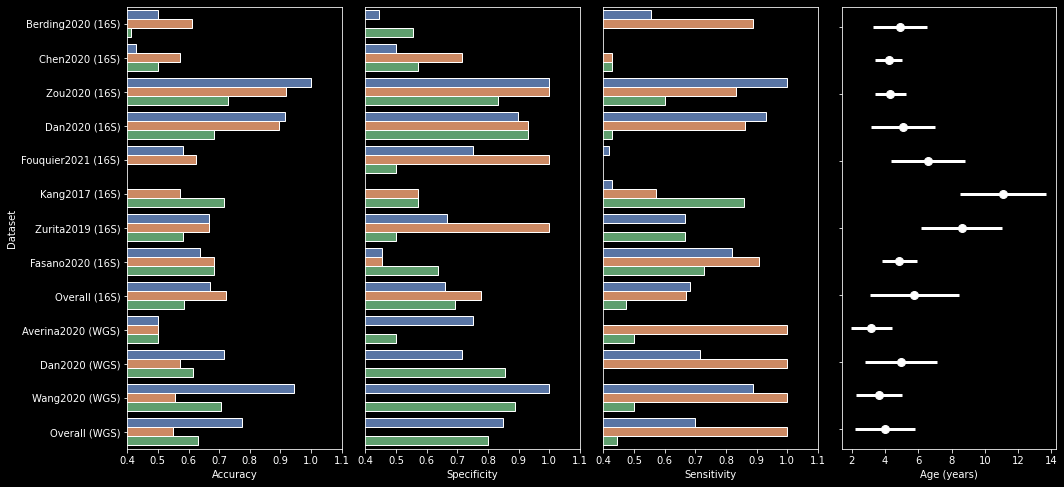

In [24]:
with plt.style.context('dark_background'):

    fig, ax = plt.subplots(1, 4, figsize=(15, 7))
    sns.set(font_scale=1.2)  # crazy big
    sns.barplot(data=cv_all_results.loc[cv_all_results['Split'] == 'test'],
                y='Dataset', x='accuracy', hue='Method', ax=ax[0])
    sns.barplot(data=cv_all_results.loc[cv_all_results['Split'] == 'test'],
                y='Dataset', x='specificity', hue='Method', ax=ax[1])
    sns.barplot(data=cv_all_results.loc[cv_all_results['Split'] == 'test'],
                y='Dataset', x='sensitivity', hue='Method', ax=ax[2])

    ax[3].errorbar(y=np.arange(len(age_stats)), x=age_stats['mean_age'], 
                   xerr=age_stats['std_age'], fmt='o', color='w', ls='none', 
                   elinewidth=3, markersize=8)
    ax[3].set_xlabel('Age (years)')
    ax[3].set_yticklabels([])

    #ax[4].scatter(y=np.arange(len(size_stats)), x=size_stats['sample_size'])
    #ax[4].set_xlabel('Sample size')
    #ax[4].set_yticklabels([])

    ax[0].legend_ = None
    ax[1].legend_ = None
    ax[2].legend_ = None

    ax[1].set_yticks([])
    ax[1].set_ylabel('')
    ax[2].set_yticks([])
    ax[2].set_ylabel('')

    ax[0].set_xlabel('Accuracy')
    ax[1].set_xlabel('Specificity')
    ax[2].set_xlabel('Sensitivity')

    ax[0].set_xlim([0.4, 1.1])
    ax[1].set_xlim([0.4, 1.1])
    ax[2].set_xlim([0.4, 1.1])
    
    for a in ax:
        a.yaxis.grid(False)
        a.xaxis.grid(False) 

    plt.tight_layout()

Only look at random forests and superimpose stats like primer type

In [25]:
rf_results = cv_all_results.loc[cv_all_results['Method'] == 'RandomForest']

primer_type = pd.DataFrame({'primer_type': pd.Series({
    'Berding2020 (16S)': 'V34',
    'Dan2020 (16S)': 'V4',
    'Zou2020 (16S)': 'V34',
    'Fouquier2021 (16S)': 'V4',
    'Zurita2019 (16S)': 'V4',
    'Kang2017 (16S)': 'V4',
    'Chen2020 (16S)': 'V34',
    'Fasano2020 (16S)': 'V45',
    'Averina2020 (WGS)': 'WGS',
    'Wang2020 (WGS)': 'WGS',
    'Dan2020 (WGS)': 'WGS' 
})})
rf_results = pd.merge(rf_results, primer_type, left_on='Dataset', right_index=True, how='outer')
rf_results = pd.merge(rf_results, size_stats['sample_size'], left_on='Dataset', right_index=True)
rf_results = pd.merge(rf_results, age_stats[['mean_age', 'std_age']], left_on='Dataset', right_index=True)
rf_results = pd.merge(rf_results, sex_stats['mf_ratio'], left_on='Dataset', right_index=True)

In [26]:
def palette_f(x):
    if 'Overall' in x:
        return '#A9A9A9'
    else:
        return palette[primer_type.loc[x, 'primer_type']]
cp = sns.color_palette('pastel')
palette={ x:list(cp)[i] for i, x in enumerate(rf_results.primer_type.unique())}
dataset_palette = {x: palette_f(x) for x in rf_results['Dataset'].unique()}

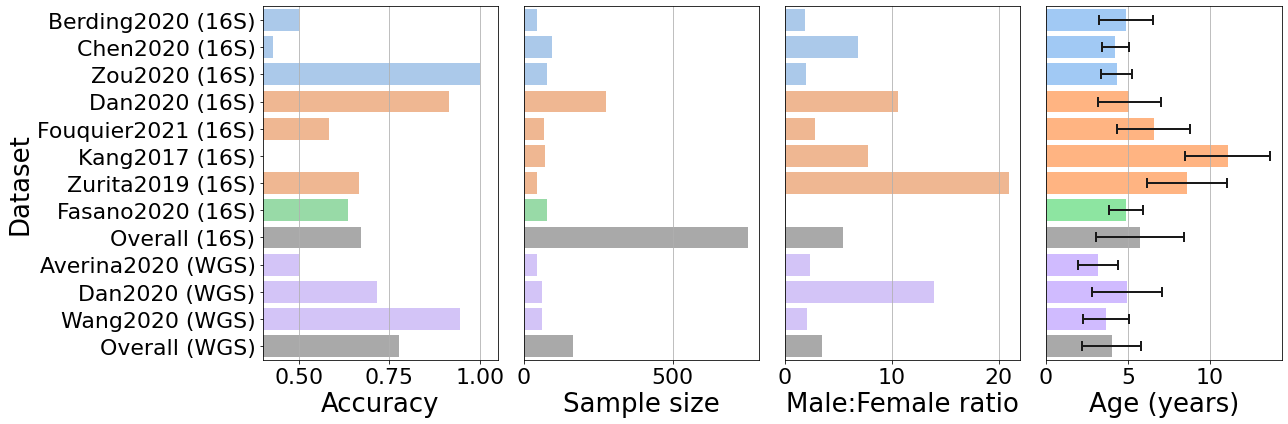

In [27]:
#with plt.style.context('dark_background'):
fs = 26
ls = 22

fig, ax = plt.subplots(1, 4, figsize=(18, 6))
sns.barplot(data=rf_results.loc[rf_results['Split'] == 'test'],
            y='Dataset', x='accuracy', ax=ax[0], palette=dataset_palette)
sns.barplot(data=rf_results, 
            y='Dataset', x='sample_size', ax=ax[1], palette=dataset_palette)
sns.barplot(data=rf_results,
            y='Dataset', x='mf_ratio', ax=ax[2], palette=dataset_palette)
"""
ax[3].errorbar(y=np.arange(len(age_stats)), x=age_stats['mean_age'], 
               xerr=age_stats['std_age'], fmt='o', 
               #color='w',
               markerfacecolor=list(pd.Series(dataset_palette).values),
               ls='none', 
               elinewidth=3, markersize=8)
"""
ax[3].barh(np.arange(len(age_stats)), age_stats['mean_age'].values,
           height=0.8, xerr=age_stats['std_age'].values,
           #color='w',
           color=list(pd.Series(dataset_palette).values[::-1]),
           error_kw=dict(ecolor='k', lw=2, capsize=5, capthick=2))

ax[3].set_ylim([-0.5, len(age_stats)-0.5])
ax[3].set_xlabel('Age (years)')

for i in range(1, len(ax)):
    ax[i].set_yticks([])
    ax[i].set_ylabel('')

ax[0].tick_params(labelsize=ls, axis='y')
ax[0].set_ylabel('Dataset', fontsize=fs)
ax[0].set_xlabel('Accuracy', fontsize=fs)
ax[1].set_xlabel('Sample size', fontsize=fs)
ax[2].set_xlabel('Male:Female ratio', fontsize=fs)
ax[3].set_xlabel('Age (years)', fontsize=fs)
ax[0].set_xlim([0.4, 1.05])
for a in ax:
    a.yaxis.grid(False)
    a.xaxis.grid(True) 
    a.tick_params(labelsize=ls, axis='x')

plt.tight_layout()

In [28]:
age_stats

,mean_age,std_age,Ordering
Overall (WGS),4.002309,1.815740,12
Wang2020 (WGS),3.645161,1.391977,11
Dan2020 (WGS),4.966667,2.138958,10
Averina2020 (WGS),3.190530,1.211962,9
Overall (16S),5.760055,2.679134,8
Fasano2020 (16S),4.865897,1.032880,7
Zurita2019 (16S),8.613636,2.432492,6
Kang2017 (16S),11.100595,2.595586,5
Fouquier2021 (16S),6.573529,2.214715,4
Dan2020 (16S),5.075540,1.924020,3


Effect sizes

In [29]:
effect_sizes = pd.Series({'Viral': 1.76, '16S': 4.28, 'SMS': 3.28, 'RNAseq': 2.29})

n_features = pd.Series({
    'Viral': 1575,
    '16S': 878,
    'SMS': 4410,
    'RNAseq': 47992
})

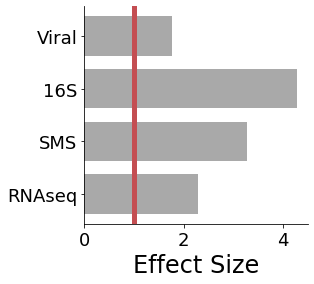

In [30]:
#with plt.style.context('dark_background'):

fig, ax = plt.subplots(figsize=(4, 4))
idx = [0, 1, 2, 3]
ax.barh(idx, effect_sizes.values[::-1], height=0.75, color='#A9A9A9')
ax.set_yticks(idx)
ax.set_yticklabels(list(effect_sizes.index)[::-1], fontsize=18)
ax.set_xlabel('Effect Size', fontsize=24)
ax.tick_params(axis='x', labelsize=18)
ax.axvline(x=1, c='r', lw=5)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

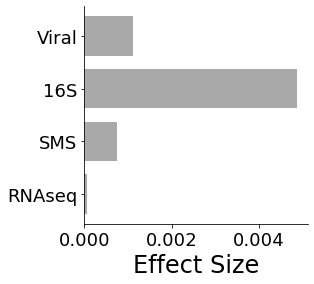

In [31]:
#with plt.style.context('dark_background'):

fig, ax = plt.subplots(figsize=(4, 4))
idx = [0, 1, 2, 3]
ax.barh(idx, (effect_sizes / n_features).values[::-1], height=0.75, color='#A9A9A9')
ax.set_yticks(idx)
ax.set_yticklabels(list(effect_sizes.index)[::-1], fontsize=18)
ax.set_xlabel('Effect Size', fontsize=24)
ax.tick_params(axis='x', labelsize=18)
#ax.axvline(x=1, c='r', lw=5)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Look more closely into accuracy

In [32]:
rf_test = rf_results.loc[rf_results['Split'] == 'test']
rf_test = rf_test.set_index('Dataset').sort_index()

(0.0, 1.1)

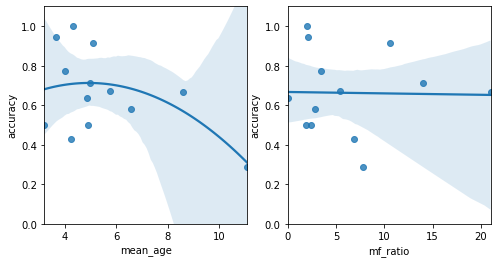

In [33]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.regplot(data=rf_test, x='mean_age', y='accuracy', order=2, ax=ax[0])
ax[0].set_ylim([0, 1.1])

sns.regplot(data=rf_test, x='mf_ratio', y='accuracy', order=1, ax=ax[1])
ax[1].set_ylim([0, 1.1])

In [34]:
rf_test

,Cohort,Method,DataType,Split,specificity,sensitivity,accuracy,Ordering,primer_type,sample_size,mean_age,std_age,mf_ratio
Dataset,,,,,,,,,,,,,
Averina2020 (WGS),Averina2020,RandomForest,WGS,test,0.750000,0.250000,0.500000,9,WGS,44,3.190530,1.211962,2.384615
Berding2020 (16S),Berding2020,RandomForest,16S,test,0.444444,0.555556,0.500000,0,V34,44,4.886364,1.631320,1.933333
Chen2020 (16S),Chen2020,RandomForest,16S,test,0.500000,0.357143,0.428571,1,V34,94,4.235106,0.810245,6.833333
Dan2020 (16S),Dan2020,RandomForest,16S,test,0.896552,0.931034,0.913793,3,V4,278,5.075540,1.924020,10.583333
Dan2020 (WGS),Dan2020,RandomForest,WGS,test,0.714286,0.714286,0.714286,10,WGS,60,4.966667,2.138958,14.000000
Fasano2020 (16S),Fasano2020,RandomForest,16S,test,0.454545,0.818182,0.636364,7,V45,78,4.865897,1.032880,0.000000
Fouquier2021 (16S),Fouquier2021,RandomForest,16S,test,0.750000,0.416667,0.583333,4,V4,68,6.573529,2.214715,2.777778
Kang2017 (16S),Kang2017,RandomForest,16S,test,0.142857,0.428571,0.285714,5,V4,70,11.100595,2.595586,7.750000
Overall (16S),Overall,RandomForest,16S,test,0.659574,0.680851,0.670213,8,NaN,754,5.760055,2.679134,5.438095


In [35]:
rf_results.loc[rf_results['Split'] == 'test']

,Cohort,Method,DataType,Split,specificity,sensitivity,accuracy,Dataset,Ordering,primer_type,sample_size,mean_age,std_age,mf_ratio
32,Berding2020,RandomForest,16S,test,0.444444,0.555556,0.500000,Berding2020 (16S),0,V34,44,4.886364,1.631320,1.933333
33,Chen2020,RandomForest,16S,test,0.500000,0.357143,0.428571,Chen2020 (16S),1,V34,94,4.235106,0.810245,6.833333
38,Zou2020,RandomForest,16S,test,1.000000,1.000000,1.000000,Zou2020 (16S),2,V34,78,4.312821,0.925309,2.000000
34,Dan2020,RandomForest,16S,test,0.896552,0.931034,0.913793,Dan2020 (16S),3,V4,278,5.075540,1.924020,10.583333
36,Fouquier2021,RandomForest,16S,test,0.750000,0.416667,0.583333,Fouquier2021 (16S),4,V4,68,6.573529,2.214715,2.777778
37,Kang2017,RandomForest,16S,test,0.142857,0.428571,0.285714,Kang2017 (16S),5,V4,70,11.100595,2.595586,7.750000
39,Zurita2019,RandomForest,16S,test,0.666667,0.666667,0.666667,Zurita2019 (16S),6,V4,44,8.613636,2.432492,21.000000
35,Fasano2020,RandomForest,16S,test,0.454545,0.818182,0.636364,Fasano2020 (16S),7,V45,78,4.865897,1.032880,0.000000
3,Overall,RandomForest,16S,test,0.659574,0.680851,0.670213,Overall (16S),8,NaN,754,5.760055,2.679134,5.438095
49,Averina2020,RandomForest,WGS,test,0.750000,0.250000,0.500000,Averina2020 (WGS),9,WGS,44,3.190530,1.211962,2.384615


In [36]:
from statsmodels.stats.proportion import binom_test

n = np.sum(amp_md['Sex'].value_counts().values[:2])
m = amp_md['Sex'].value_counts().values[0]

binom_test(m, n, prop=1/3, alternative='two-sided')

3.329894705280398e-166

In [37]:
n = np.sum(wgs_md['Sex'].value_counts().values[:2])
m = wgs_md['Sex'].value_counts().values[0]

binom_test(m, n, prop=1/3, alternative='two-sided')

1.3218389860025705e-31

In [38]:
amp_md['Sex'].value_counts()

male       571
female     105
Unknown     78
Name: Sex, dtype: int64